## Basic Information Analysis 

### Inputs: 

- PAPERS_INFOR/JITS/JITS_PAPER_INFO
- PAPERS_INFOR/JITS/JITS_PAPER_ABSTRACT
- UTILS/STOP_WORDS -- TODO: refine stop words for jits purpose
- UTILS/PLURAL_WORDS -- TODO: another stemmation method necessary

### Outputs:

- PAPERS_INFO/PROCESSED/JITS_REGULAR


In [21]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import LatentDirichletAllocation as LDA 
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

In [22]:
papers = pd.read_csv('../papers_info/jits/jits_paper_info.csv')
abstracts = pd.read_csv('../papers_info/jits/jits_paper_abstracts.csv')
stop_words = pd.read_csv('../utils/stop_words.txt', header=None, names = ['words']) # remove using and based
plural_words = pd.read_csv('../utils/plural_words.txt', header=None, names=['plural', 'singular']).set_index('plural').T.to_dict('records')[0]

### *(abstracts.csv)* pre-processing and a short summary

In [23]:
# pre-processing of papers
papers['paper_type'] = 'regular'
papers.loc[papers.title.str.contains('overview'), 'paper_type'] = 'review'
papers = papers[papers['paper_type'] == 'regular']

# remove punctuation paper titles
papers['title_pro']  = papers['title'].map(lambda x: re.sub('[^\x00-\x7f]', '', x))
papers.title_pro = papers.title_pro.map(lambda x: re.sub(r'[^\w]', ' ', x)) 
papers.title_pro = papers.title_pro.map(lambda x: x.lower())

# summary
summary = papers[['paper_id', 'year', 'paper_type']].groupby(['year', 'paper_type']).count().reset_index()
print("Total number of papers (2010-2020): %d." % (sum(summary.paper_id)))

most_cited = papers[papers.cited == max(papers.cited)]
print("Most cited (2010-2020): %s, published in %s, cited by %s times." % (most_cited.iloc[0]['title'], most_cited.iloc[0]['year'], most_cited.iloc[0]['cited']))

Total number of papers (2010-2020): 306.
Most cited (2010-2020): Intersection Management via Vehicle Connectivity: The Intersection Cooperative Adaptive Cruise Control System Concept, published in 2016, cited by 64 times.


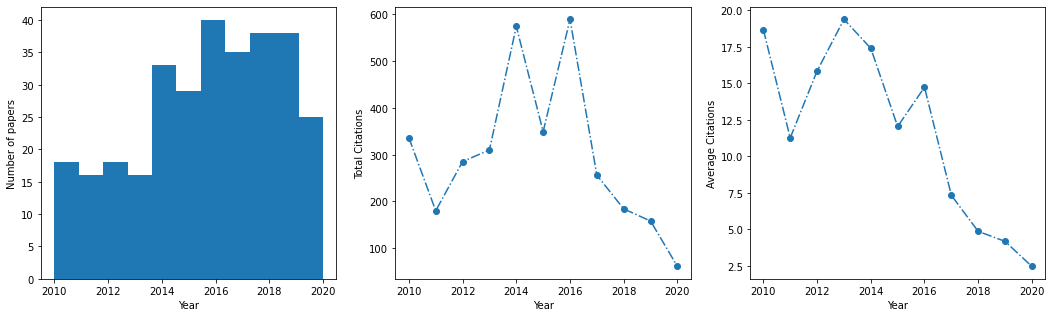

In [24]:
# Basic information
groups = papers.groupby('year')
avg_cited_per_year = groups.mean('cited').reset_index()
sum_cited_per_year = groups.sum('cited').reset_index()

f = plt.figure(figsize = (18, 5))

plt.subplot(1, 3, 1)
plt.hist(papers.year, bins = 11)
plt.xlabel('Year')
plt.ylabel('Number of papers')

plt.subplot(1, 3, 2)
plt.plot(sum_cited_per_year.year, sum_cited_per_year.cited, '-.o', label = 'Total citations per year')
plt.xlabel('Year')
plt.ylabel('Total Citations')

plt.subplot(1, 3, 3)
plt.plot(avg_cited_per_year.year, avg_cited_per_year.cited, '-.o', label = 'Average citations per year')
plt.xlabel('Year')
plt.ylabel('Average Citations')

plt.show()

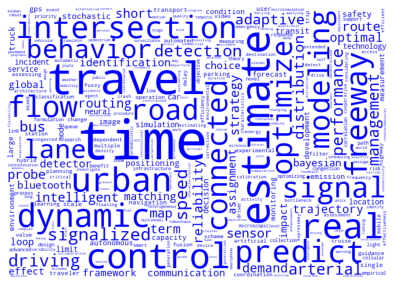

In [25]:
# word cloud on title
all_words = " ".join(list(papers.title_pro.values))
all_words.replace("ad hoc", "ad-hoc")
tokens = nltk.word_tokenize(all_words)
lemma = nltk.PorterStemmer()
stems = [plural_words[w] for w in tokens if w in plural_words]
non_stems = [w for w in tokens if w not in plural_words]
all_words_stemmed = stems + non_stems

count_vec = TfidfVectorizer(stop_words = set(stop_words.words.values))
count_data = count_vec.fit_transform(all_words_stemmed)
words = count_vec.get_feature_names()

word_counts = count_data.toarray().sum(axis = 0)
count_dict = dict(zip(words, word_counts))
sorted_counts = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)

wordcloud = WordCloud(background_color = 'white', max_words = 300, contour_color = 'steelblue', contour_width = 2, height = 500, width = 700, random_state = 1042, max_font_size=100)
wordcloud.generate_from_frequencies(count_dict)

def gen_color(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return 'rgb(0, 0, 255)'
    
plt.figure(figsize = (7,5))
plt.imshow(wordcloud.recolor(color_func=gen_color))
plt.axis('off')
plt.show()

## Abstract analysis

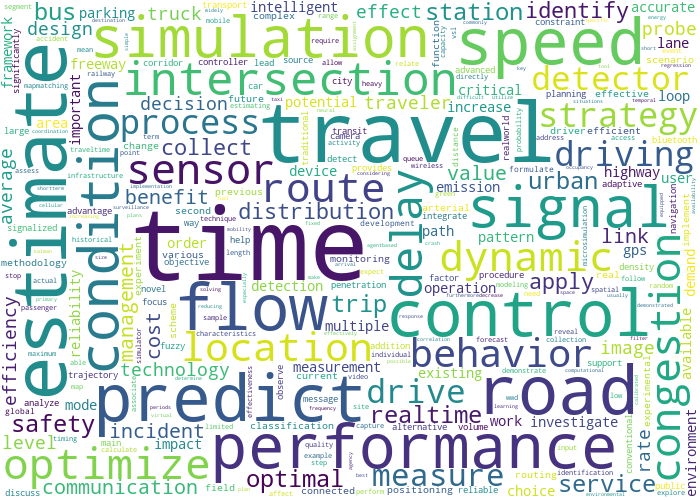

In [26]:
abstracts['abstract_pro']  = abstracts['abstract'].map(lambda x: re.sub('[^\x00-\x7f]', '', x))
abstracts.abstract_pro = abstracts.abstract_pro.map(lambda x: re.sub(r'\((.*?)\)', '', x)) 
abstracts.abstract_pro = abstracts.abstract_pro.map(lambda x: x.lower())
abstracts.abstract_pro = abstracts.abstract_pro.map(lambda x: re.sub(r'[-*,./:?!\'%0-9]', '', x)) 
abstracts_pro = abstracts.merge(papers, on="paper_id")[['paper_id', 'abstract_pro', 'year']]

papers = papers.merge(abstracts, on = 'paper_id')
papers.to_csv('../papers_info/processed/jits_regular.csv', index=False)


# word cloud on title
all_words = " ".join(list(abstracts_pro.abstract_pro.values))
all_words.replace("ad hoc", "ad-hoc")
tokens = nltk.word_tokenize(all_words)
lemma = nltk.PorterStemmer()
stems = [plural_words[w] for w in tokens if w in plural_words]
non_stems = [w for w in tokens if w not in plural_words]
all_words_stemmed = stems + non_stems

count_vec = TfidfVectorizer(stop_words = set(stop_words.words.values))
count_data = count_vec.fit_transform(all_words_stemmed)
words = count_vec.get_feature_names()
#print("Vocabulary (JITS Abstract): %d" % len(words))

word_counts = count_data.toarray().sum(axis = 0)
count_dict = dict(zip(words, word_counts))
sorted_counts = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)

wordcloud = WordCloud(background_color = 'white', max_words = 300, contour_color = 'steelblue', random_state = 1042, max_font_size=100, height = 500, width = 700)
wordcloud.generate_from_frequencies(count_dict)
wordcloud.to_image()

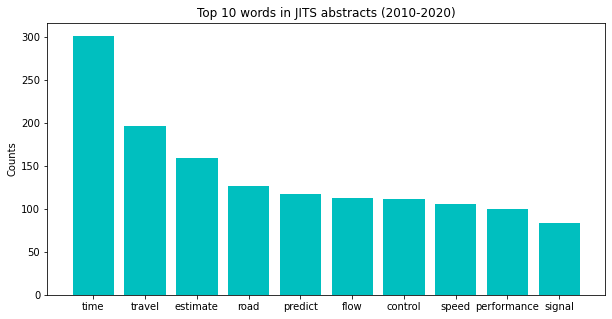

In [27]:
plt.figure(figsize=(10,5))

top_10_words = [w[0] for w in sorted_counts[:10]]
top_10_word_counts = [w[1] for w in sorted_counts[:10]]

plt.bar(top_10_words, top_10_word_counts, color = 'c')
plt.title('Top 10 words in JITS abstracts (2010-2020)')
plt.ylabel('Counts')

plt.show()

In [28]:
number_topics = 5
number_words = 5

lda = LDA(n_components = number_topics, n_jobs = -1, random_state = 1000)
lda.fit(count_data)
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d: %s" % (topic_idx+1, " ".join(words[i] for i in topic.argsort()[:-number_words -1:-1])))    

prep = sklearn_lda.prepare(lda, count_data, count_vec)
pyLDAvis.save_html(prep, 'jits_lda_abstracts.html')

Topic 1: time condition delay congestion detector
Topic 2: control simulation route location driving
Topic 3: estimate road predict flow speed
Topic 4: intersection optimal safety distribution technology
Topic 5: travel performance signal optimize sensor
